In [1]:
import pandas as pd
from os import getcwd

import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans


import matplotlib.pyplot as plt 

getcwd()

'C:\\Users\\Alec\\Documents\\Programming_Resources\\Boot_Camp\\20_unsupervised_learning\\homework'

In [2]:
infile_01 = 'crypto_data.csv'

df = pd.read_csv(infile_01,index_col=0)
df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [3]:
# observe values and agg data of columns

df.describe()

,TotalCoinsMined
count,7.440000e+02
mean,3.883103e+09
std,3.867263e+10
min,-5.917978e+09
25%,6.322164e+05
50%,1.340427e+07
75%,9.399895e+07
max,9.899887e+11


In [4]:
# observe the data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1252 entries, 42 to PUNK
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CoinName         1252 non-null   object 
 1   Algorithm        1252 non-null   object 
 2   IsTrading        1252 non-null   bool   
 3   ProofType        1252 non-null   object 
 4   TotalCoinsMined  744 non-null    float64
 5   TotalCoinSupply  1252 non-null   object 
dtypes: bool(1), float64(1), object(4)
memory usage: 59.9+ KB


In [5]:
# convert the data into best dtypes
df = df.convert_dtypes()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1252 entries, 42 to PUNK
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CoinName         1252 non-null   string 
 1   Algorithm        1252 non-null   string 
 2   IsTrading        1252 non-null   boolean
 3   ProofType        1252 non-null   string 
 4   TotalCoinsMined  744 non-null    Float64
 5   TotalCoinSupply  1252 non-null   string 
dtypes: Float64(1), boolean(1), string(4)
memory usage: 62.4+ KB


In [7]:
# format the total coin supply to remove unneeded commas,whitespace,and periods
strip_list = []
old_list = df['TotalCoinSupply'].to_list()
for i in range(len(old_list)):
    entry=old_list[i].replace('.','').replace(' ','').replace(',','')
   
    strip_list.append(entry)

In [8]:
df['TotalCoinSupply'] = strip_list

In [9]:
# convert strings to int64 now that formatting has been completed
df['TotalCoinSupply']=pd.to_numeric(df['TotalCoinSupply'],downcast='float')

In [10]:
# observe changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1252 entries, 42 to PUNK
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CoinName         1252 non-null   string 
 1   Algorithm        1252 non-null   string 
 2   IsTrading        1252 non-null   boolean
 3   ProofType        1252 non-null   string 
 4   TotalCoinsMined  744 non-null    Float64
 5   TotalCoinSupply  1252 non-null   float32
dtypes: Float64(1), boolean(1), float32(1), string(3)
memory usage: 57.5+ KB


In [11]:
# test for duplicated columns
dupes = df.duplicated()
dupes.value_counts()

False    1252
dtype: int64

In [12]:
# compare to row count just because I don't trust things.
len(df.index)

1252

### Data has been observed, Cleaning Time

In [13]:
# Find null values
for column in df.columns:
    print(f"Column - {column} has {df[column].isnull().sum()} null values")

Column - CoinName has 0 null values
Column - Algorithm has 0 null values
Column - IsTrading has 0 null values
Column - ProofType has 0 null values
Column - TotalCoinsMined has 508 null values
Column - TotalCoinSupply has 0 null values


In [14]:
# drop currencies not being traded
df_trading = df.loc[df['IsTrading'] == True]
df_mined = df_trading.loc[df_trading['TotalCoinsMined']>0]
df_clean = df_mined.drop(columns=['IsTrading','CoinName'],axis=1)

In [15]:
# drop all NaN
df_clean = df_clean.dropna(how='any')

In [16]:
# show data loss as percentage
print(f'Rows in initial DF -> {len(df_trading.index)}')
print(f'Rows with No NaN DF -> {len(df_clean.index)}')
print(f'{round((len(df_clean.index)) / (len(df_trading.index)) * 100,2)}% information was NaN')

Rows in initial DF -> 1144
Rows with No NaN DF -> 532
46.5% information was NaN


#### reset the index
df_clean=df_clean.reset_index(drop=False)

In [17]:
df_clean

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,41.999954,4.200000e+01
404,Scrypt,PoW/PoS,1055184902.04,5.320000e+08
1337,X13,PoW/PoS,29279424622.502701,3.141593e+11
BTC,SHA-256,PoW,17927175.0,2.100000e+07
ETH,Ethash,PoW,107684222.6865,0.000000e+00
...,...,...,...,...
ZEPH,SHA-256,DPoS,1999999995.3056,2.000000e+09
GAP,Scrypt,PoW/PoS,14931046.154661,2.500000e+08
BDX,CryptoNight,PoW,980222595.0,1.400223e+09
ZEN,Equihash,PoW,7296537.5,2.100000e+07


In [18]:
# process the string data into dummy columns for model
X_dummies = pd.get_dummies(data = df_clean, columns = ['Algorithm','ProofType'])
X_dummies.shape

(532, 98)

In [19]:
X_dummies

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,41.999954,4.200000e+01,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1055184902.04,5.320000e+08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,29279424622.502701,3.141593e+11,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,17927175.0,2.100000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,107684222.6865,0.000000e+00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZEPH,1999999995.3056,2.000000e+09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GAP,14931046.154661,2.500000e+08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BDX,980222595.0,1.400223e+09,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZEN,7296537.5,2.100000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# scale the data to lessen bias
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummies)
X_scaled.shape

(532, 98)

In [21]:
# dimensionality reduction using PCA
pca = PCA(n_components=.9)
components = pca.fit_transform(X_scaled)
components.shape

(532, 75)

In [33]:
# dimensionality reduction using t-SNE
X_embedded = TSNE(perplexity=30).fit_transform(components)
X_embedded.shape

(532, 2)

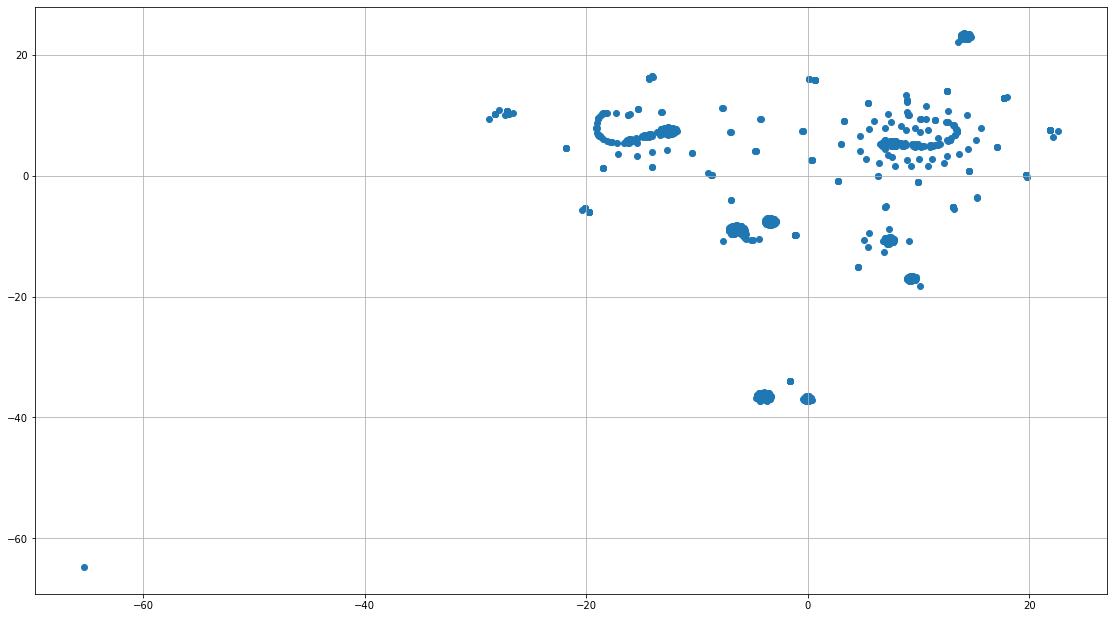

In [34]:
fig = plt.figure(figsize = (19.20,10.80))

plt.scatter(X_embedded[:,0],X_embedded[:,1])
plt.grid()
plt.show()

In [35]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X_embedded)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow

C:\Users\Alec\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,k,inertia
0,1,199615.093750
1,2,127197.835938
2,3,60418.531250
3,4,35354.097656
4,5,29291.068359
5,6,24054.046875
6,7,19980.822266
7,8,16190.086914
8,9,13747.078125
9,10,11518.289062


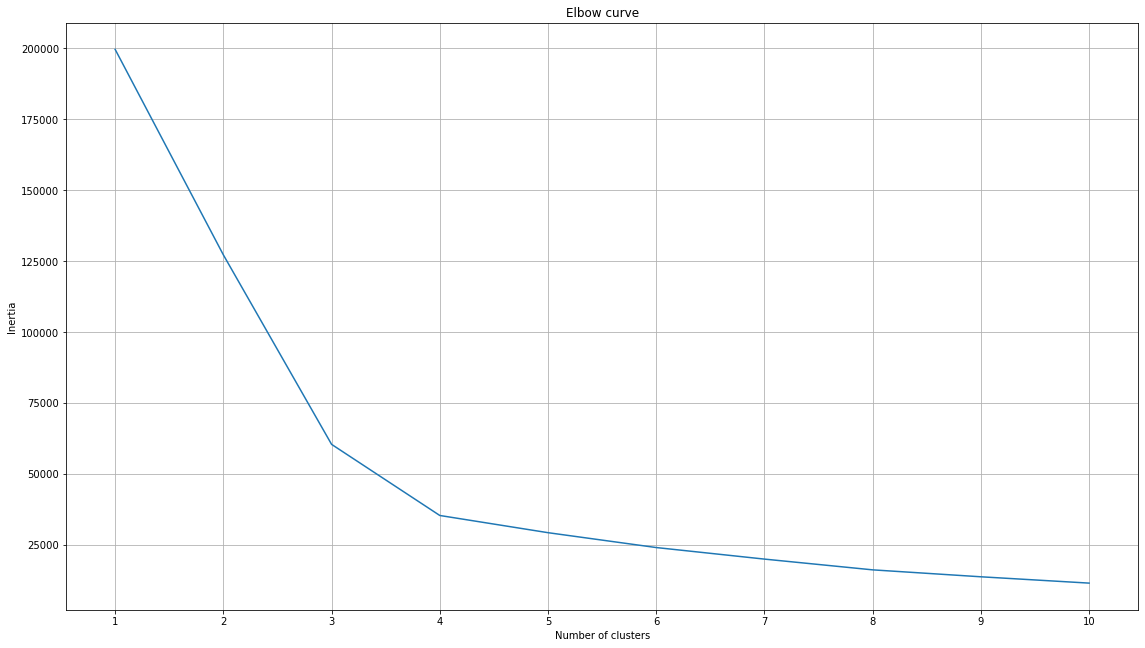

In [36]:
# Plot the elbow curve to find the best candidate(s) for k

fig = plt.figure(figsize = (19.20,10.80))

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve')
plt.grid()
plt.show()

In [37]:
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [38]:
# transform embedded array into df for clustering purposes
cluster_df = pd.DataFrame(X_embedded, columns=['col_1','col_2'])

In [39]:
# display the cluster df
cluster_df

,col_1,col_2
0,-11.887165,7.713398
1,-18.481525,10.314414
2,-26.954508,10.302923
3,-3.546642,-36.027901
4,17.738503,12.828630
...,...,...
527,15.247792,-3.676458
528,-15.436979,6.125570
529,14.443521,22.717276
530,21.912918,7.499741


In [40]:
# after plotting the inertia of the K-means cluster data, 4 clusters was determined to be the best
clusters = get_clusters(4, cluster_df) 

In [41]:
# cluster_df with defined classes
clusters

,col_1,col_2,class
0,-11.887165,7.713398,1
1,-18.481525,10.314414,1
2,-26.954508,10.302923,1
3,-3.546642,-36.027901,2
4,17.738503,12.828630,0
...,...,...,...
527,15.247792,-3.676458,0
528,-15.436979,6.125570,1
529,14.443521,22.717276,0
530,21.912918,7.499741,0


In [42]:
def show_clusters(df):
    fig = plt.figure(figsize = (19.20,10.80))

    plt.scatter(df['col_1'], df['col_2'], c=df['class'])
    plt.xlabel('col_1')
    plt.ylabel('col_2')
    plt.grid()
    plt.show()

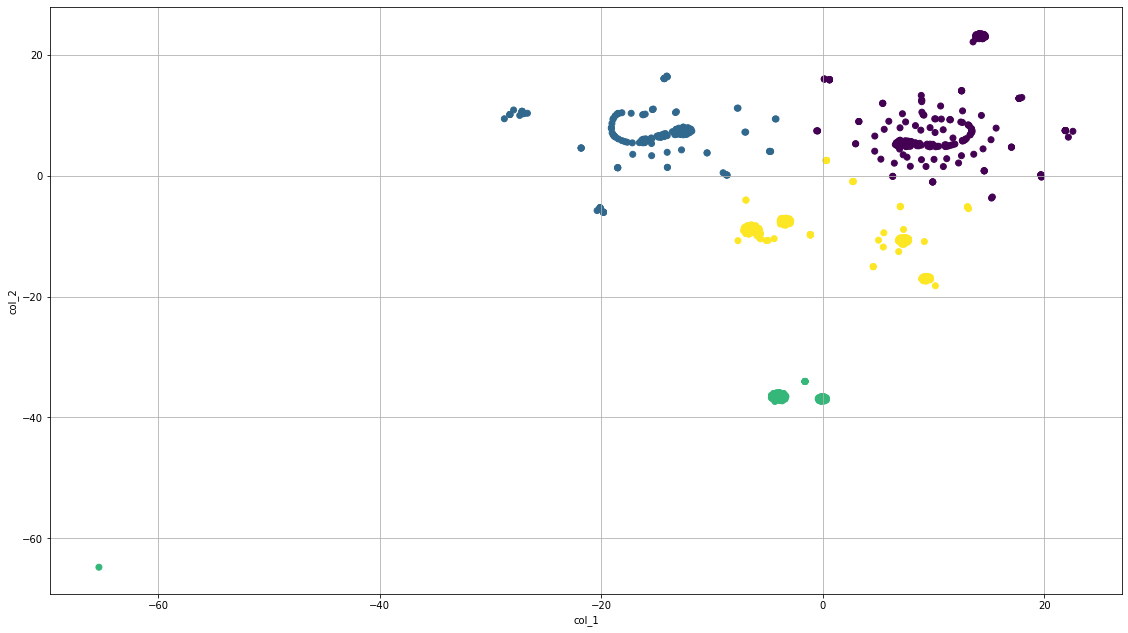

In [43]:
show_clusters(clusters)

# Conclusion:

Ignoring the loss of data I would not reccomend unsupervised learing - grouping using K-means, as a reliable method of clustering. The data may be too varied to accurately cluster due to the volitile nature of crypto currencies. Subtle clusters may be present but after multiple runs of this script with varying hyper parameters for t-SNE, this result was the cleanest and most concise clustering found.

### With consideration to the loss of data post-processing:

Once cleaning was complete and NaN values removed, only 46.5% of the initial data remained for testing which drastically reduced the amount of information used to train the Unsupervised Model. I would give this unsupervised model another chance with a more robust dataset just to observe the potential change in clusters, were they to exist.